# Lab01 - Image Segmentation
Full name: Bùi Thị Thanh Phương

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_multiotsu, threshold_niblack, threshold_sauvola
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
import pandas as pd
import json
import os
import timeit
import random

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [3]:
def get_subfiles(dir):
    "Get a list of immediate subfiles"
    return next(os.walk(dir))[2]

In [4]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth 
    Height = DesiredHeight

    if((Width == 0) & (Height == 0)):
        return IM
    
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)

    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)

    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST) 
    return resizedIM

In [5]:
def p_tile_threshold(image, pct):
  """Runs the p-tile threshold algorithm.
  Reference:
  Parker, J. R. (2010). Algorithms for image processing and
  computer vision. John Wiley & Sons.
  @param image: The input image
  @type image: ndarray
  @param pct: The percent of desired background pixels (black pixels).
      It must lie in the interval [0, 1]
  @type pct: float
  @return: The p-tile global threshold
  @rtype int
  """
  n_pixels = pct * image.shape[0] * image.shape[1]
  hist = np.histogram(image, bins=range(256))[0]
  hist = np.cumsum(hist)

  return np.argmin(np.abs(hist - n_pixels))

In [6]:
def otsu(gray):
  pixel_number = gray.shape[0] * gray.shape[1]
  mean_weigth = 1.0/pixel_number
  his, bins = np.histogram(gray, np.array(range(0, 256)))
  final_thresh = -1
  final_value = -1

  WBackground = []
  WForeground = []
  Values = []
  
  for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
      Wb = np.sum(his[:t]) * mean_weigth
      Wf = np.sum(his[t:]) * mean_weigth

      mub = np.mean(his[:t])
      muf = np.mean(his[t:])

      value = Wb * Wf * (mub - muf) ** 2
      # print("Wb", Wb, "Wf", Wf)
      # print("t", t, "value", value)
      WBackground.append(Wb)
      WForeground.append(Wf)
      Values.append(value)

      if value > final_value:
          final_thresh = t
          final_value = value

  final_img = gray.copy()
  print("Otsu threshold: ",final_thresh)
  final_img[gray > final_thresh] = 255
  final_img[gray < final_thresh] = 0
  return final_img, final_thresh, [WBackground, WForeground, Values]

In [7]:
def min_err_threshold(image):
    """Runs the minimum error thresholding algorithm.
    Reference:
    Kittler, J. and J. Illingworth. ‘‘On Threshold Selection Using Clustering
    Criteria,’’ IEEE Transactions on Systems, Man, and Cybernetics 15, no. 5
    (1985): 652–655.
    @param image: The input image
    @type image: ndarray
    @return: The threshold that minimize the error
    @rtype: int
    """
    # Input image histogram
    hist = np.histogram(image, bins=range(256))[0].astype(np.float)

    # The number of background pixels for each threshold
    w_backg = hist.cumsum()
    w_backg[w_backg == 0] = 1  # to avoid divisions by zero

    # The number of foreground pixels for each threshold
    w_foreg = w_backg[-1] - w_backg
    w_foreg[w_foreg == 0] = 1  # to avoid divisions by zero

    # Cumulative distribution function
    cdf = np.cumsum(hist * np.arange(len(hist)))

    # Means (Last term is to avoid divisions by zero)
    b_mean = cdf / w_backg
    f_mean = (cdf[-1] - cdf) / w_foreg

    # Standard deviations
    b_std = ((np.arange(len(hist)) - b_mean)**2 * hist).cumsum() / w_backg
    f_std = ((np.arange(len(hist)) - f_mean) ** 2 * hist).cumsum()
    f_std = (f_std[-1] - f_std) / w_foreg

    # To avoid log of 0 invalid calculations
    b_std[b_std == 0] = 1
    f_std[f_std == 0] = 1

    # Estimating error
    error_a = w_backg * np.log(b_std) + w_foreg * np.log(f_std)
    error_b = w_backg * np.log(w_backg) + w_foreg * np.log(w_foreg)
    error = 1 + 2 * error_a - 2 * error_b

    final_img = image.copy()
    final_thresh = np.argmin(error)
    print("The threshold that minimize the error: ",final_thresh)
    final_img[image > final_thresh] = 255
    final_img[image < final_thresh] = 0

    return final_img, final_thresh

In [8]:
def two_peaks_threshold(image, smooth_hist=True, sigma=5):
    from scipy.ndimage import gaussian_filter
    """Runs the two peaks threshold algorithm. It selects two peaks
    from the histogram and return the index of the minimum value
    between them.
    The first peak is deemed to be the maximum value fo the histogram,
    while the algorithm will look for the second peak by multiplying the
    histogram values by the square of the distance from the first peak.
    This gives preference to peaks that are not close to the maximum.
    Reference:
    Parker, J. R. (2010). Algorithms for image processing and
    computer vision. John Wiley & Sons.
    @param image: The input image
    @type image: ndarray
    @param smooth_hist: Indicates whether to smooth the input image
        histogram before finding peaks.
    @type smooth_hist: bool
    @param sigma: The sigma value for the gaussian function used to
        smooth the histogram.
    @type sigma: int
    @return: The threshold between the two founded peaks with the
        minimum histogram value
    @rtype: int
    """
    hist = np.histogram(image, bins=range(256))[0].astype(np.float)
    plt.plot(hist)
    plt.title("Histogram of Image")
    plt.show()

    if smooth_hist:
        hist = gaussian_filter(hist, sigma=sigma)
        # plt.plot(hist)
        # plt.title("Histogram of Image after smoothing")
        # plt.show()

    f_peak = np.argmax(hist)
    
    # finding second peak
    s_peak = np.argmax((np.arange(len(hist)) - f_peak) ** 2 * hist)
    
    thr = np.argmin(hist[min(f_peak, s_peak): max(f_peak, s_peak)])
    thr += min(f_peak, s_peak)

    final_img = image.copy()
    print("The threshold between the two founded peaks with the minimum histogram value: ",thr)
    final_img[image > thr] = 255
    final_img[image < thr] = 0

    return final_img, thr, hist

In [9]:
def multi_Otsu_Plot(image_gray, classes=3, return_regions=False):
  # Applying multi-Otsu threshold for the default value, generating
  # three classes.
  thresholds = threshold_multiotsu(image_gray,classes=classes)
  # Using the threshold values, we generate the three regions.
  regions = np.digitize(image_gray, bins=thresholds)

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
  # Plotting the original image.
  ax[0].imshow(image_gray, cmap='gray')
  ax[0].set_title('Original')
  ax[0].axis('off')
  # Plotting the histogram and the two thresholds obtained from
  # multi-Otsu.
  ax[1].hist(image_gray.ravel(), bins=255)
  ax[1].set_title('Histogram')
  for thresh in thresholds:
      ax[1].axvline(thresh, color='r')
  # Plotting the Multi Otsu result.
  ax[2].imshow(regions, cmap='jet')
  ax[2].set_title('Multi-Otsu result')
  ax[2].axis('off')
  plt.subplots_adjust()
  plt.show()
  if return_regions:
    return regions

In [10]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [11]:
def SegmentColorImageByMask(IM, Mask):
  Mask = Mask.astype(np.uint8)
  result = cv2.bitwise_and(IM, IM, mask = Mask)
  return result

In [12]:
def morphology(Mask, Size):
  from skimage.morphology import erosion, dilation, opening, closing, white_tophat
  from skimage.morphology import disk
  selem = disk(abs(Size))
  if (Size > 0):
    result = dilation(Mask, selem)
  else:
    result = erosion(Mask, selem)
  return result

In [13]:
# Mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
path_Data = "/content/gdrive/MyDrive/HK2 Nam3/BHXLA/Object Segmentation Data/"
checkPath = os.path.isdir(path_Data)
print("The path and file are valid or not :", checkPath)  

The path and file are valid or not : True


In [15]:
all_names = get_subfiles(path_Data)
print("Number of Images:", len(all_names))
IMG = [] 
for i in range(len(all_names)):   
    tmp = plt.imread(path_Data + all_names[i])
    IMG.append(tmp)
    
ImageDB = IMG.copy()
NameDB = all_names

Number of Images: 28


1. Thực hiện tốt hơn việc segmentation bàn tay với các phần xương, da và background bằng các thuật toán global và local thresholding.

Selected Image :  
Index  12 
Name  Hand.jpg


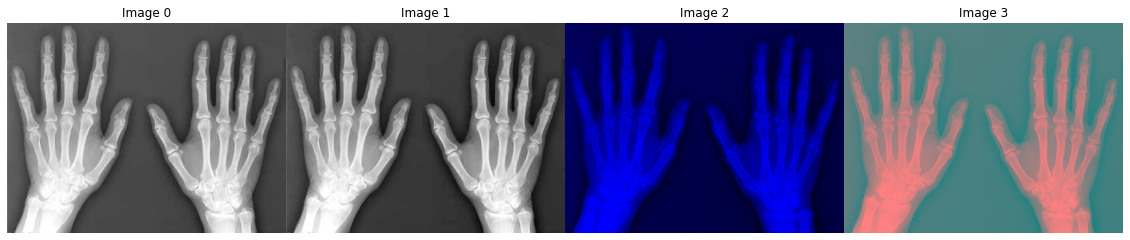

In [16]:
FileName = 'Hand.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_RGB2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

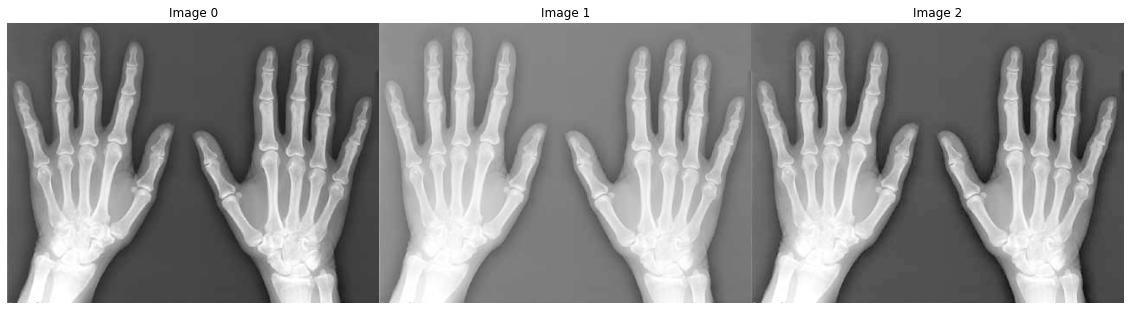

In [17]:
adjusted = adjust_gamma(image_orig, gamma=1.8)
image_gray = cv2.cvtColor(adjusted,cv2.COLOR_BGR2GRAY)
ShowImage([image_orig, adjusted, image_gray],1,3)

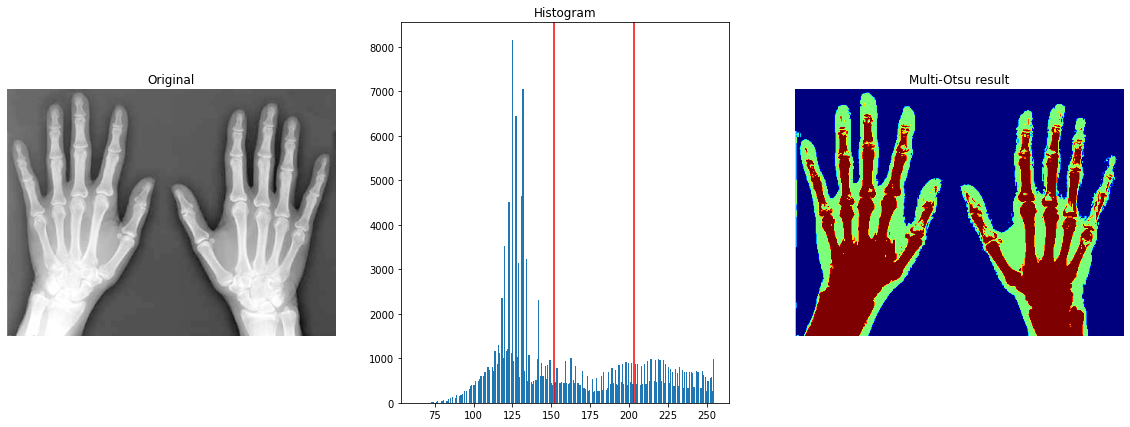

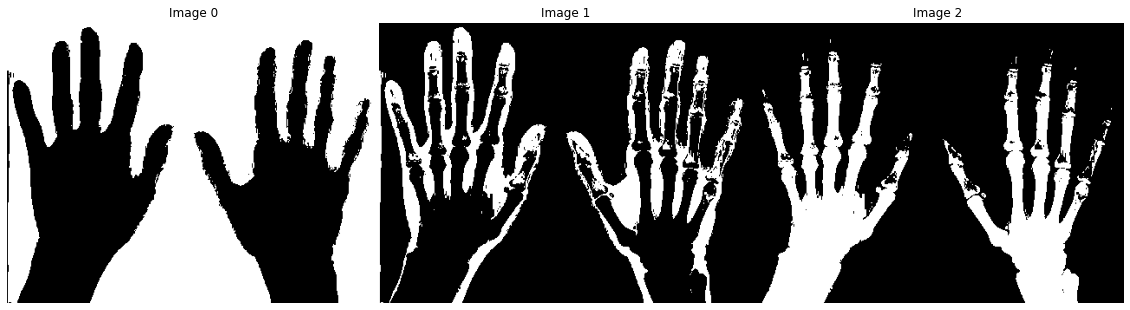

In [18]:
regions = multi_Otsu_Plot(image_gray, return_regions=True, classes=3)
Segments = []
for idx in list(np.unique(regions)):
  mask = regions == idx
  Segments.append(mask)
 
ShowImage(Segments, 1, len(Segments))

2. Chọn thêm 2 ví dụ trong danh sách hình và định nghĩa object cần segment trong các hình là gì và thực hiện segmentation tốt nhất bằng global và local thresholding.

Selected Image :  
Index  16 
Name  Emotion.jpg


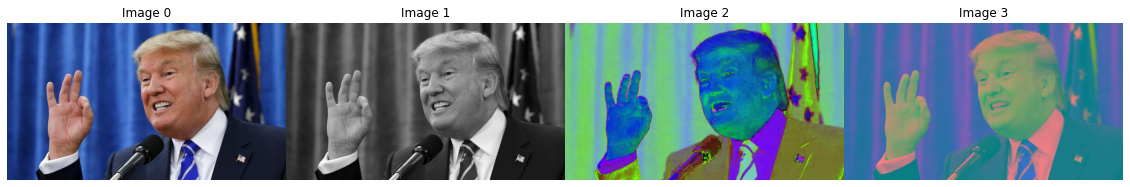

In [19]:
FileName = 'Emotion.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_RGB2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

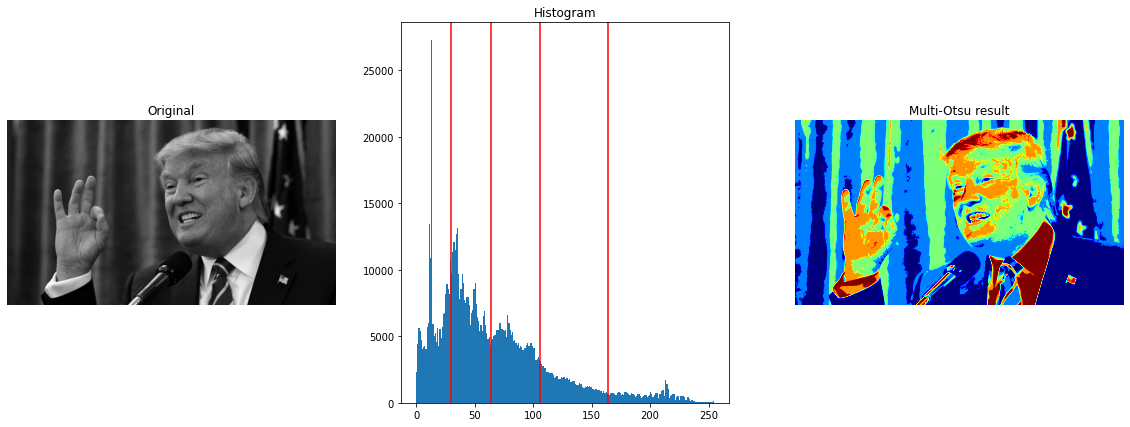

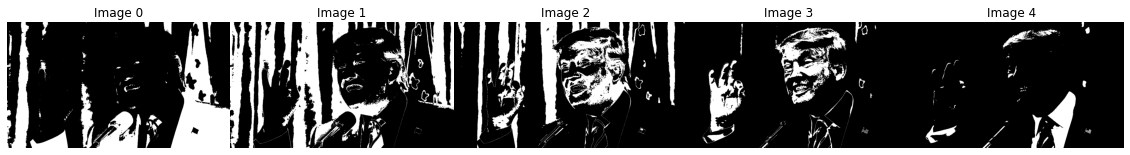

In [20]:
adjusted = adjust_gamma(image_orig, gamma=0.75)
image_gray = cv2.cvtColor(adjusted,cv2.COLOR_RGB2GRAY)
regions = multi_Otsu_Plot(image_gray, classes=5, return_regions=True)
Segments = []
for idx in list(np.unique(regions)):
  mask = regions == idx
  Segments.append(mask)
ShowImage(Segments, 1, len(Segments))

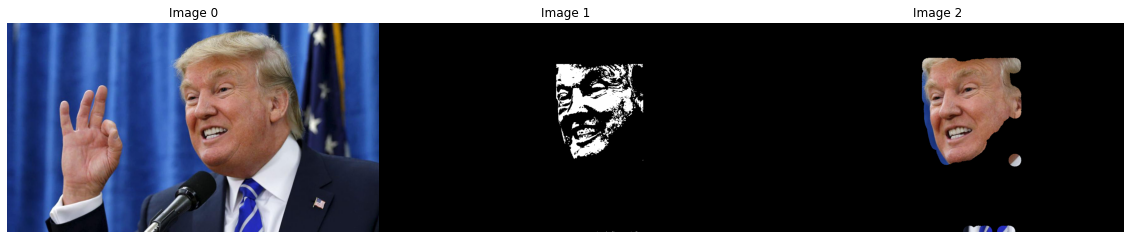

In [21]:
Segment = Segments[3].copy()
Segment[:,0:570] = 0
Segment[:,-350:-1]=0
Segment[-230:-1,:] = 0
Segment[0:135,:] = 0
Segment_morpho = morphology(Segment, 20)
final_segment = SegmentColorImageByMask(image_orig, Segment_morpho)
ShowImage([image_orig, Segment, final_segment], 1,3)

Selected Image :  
Index  26 
Name  Writing.png


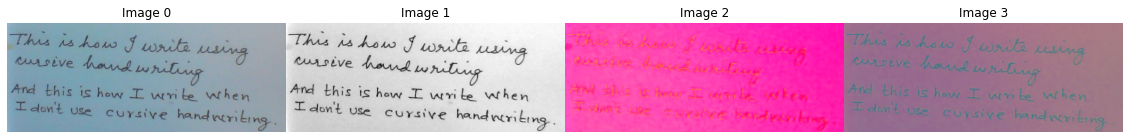

In [22]:
FileName = 'Writing.png'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_RGB2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

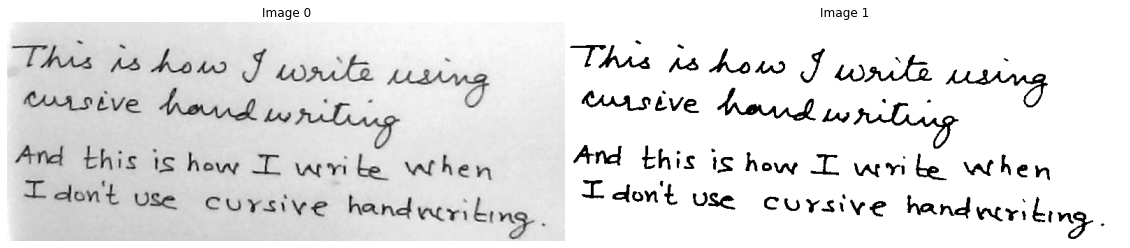

In [23]:
image = image_gray
binary_global = image > threshold_otsu(image)
ShowImage([image, binary_global], 1, 2)

Selected Image :  
Index  5 
Name  Fire.jpg


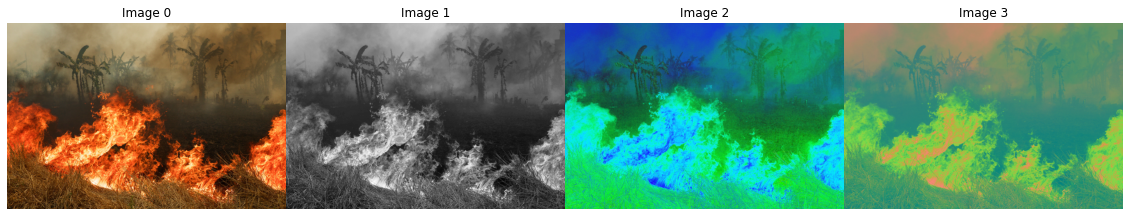

In [24]:
FileName = 'Fire.jpg'
idx = NameDB.index(FileName)
print("Selected Image : ", "\nIndex ", idx, "\nName ", NameDB[idx])

image_orig = ImageDB[idx]
image_gray = cv2.cvtColor(image_orig,cv2.COLOR_RGB2GRAY)
image_hsv = cv2.cvtColor(image_orig, cv2.COLOR_RGB2HSV)
image_ycbcr = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YCR_CB)
ShowImage([image_orig, image_gray, image_hsv, image_ycbcr], 1, 4)

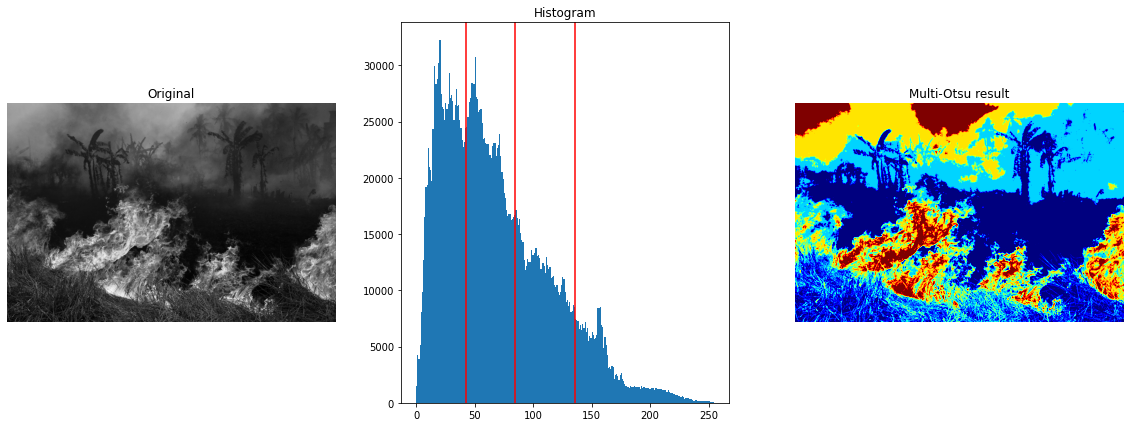

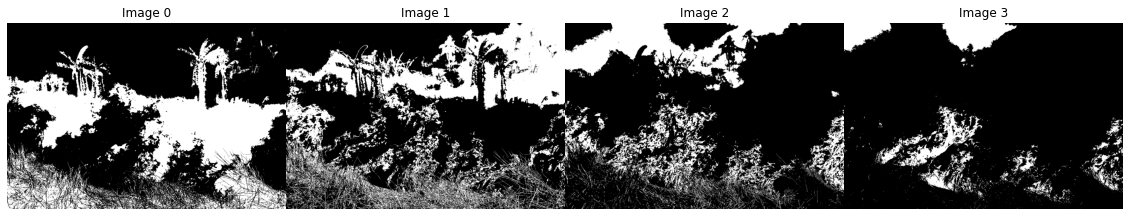

In [25]:
adjusted = adjust_gamma(image_orig, gamma=0.7)
image_gray = cv2.cvtColor(adjusted,cv2.COLOR_RGB2GRAY)
regions = multi_Otsu_Plot(image_gray, classes=4, return_regions=True)
Segments = []
for idx in list(np.unique(regions)):
  mask = regions == idx
  Segments.append(mask)
ShowImage(Segments, 1, len(Segments))

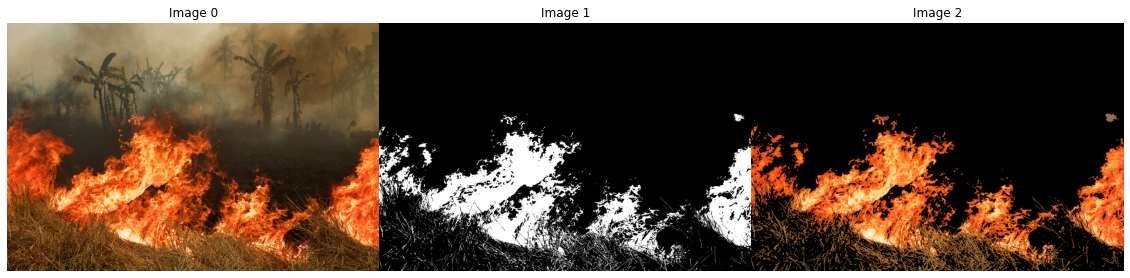

In [26]:
Segment = np.bitwise_or(Segments[2], Segments[3])
Segment[0:500,:] = 0
Segment_morpho = morphology(Segment, 2)
final_segment = SegmentColorImageByMask(image_orig, Segment_morpho)
ShowImage([image_orig, Segment, final_segment], 1,3)